In [1]:
from __future__ import division, print_function
import sqlalchemy
import imp
import pandas as pd
import os
import src.preprocessing as preprocessing
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import datetime

In [108]:
sys.path.append(os.path.join( '..', 'data'))
from build_db import connect

# Load Data

In [26]:
# connect to db
db_name = 'dota-draft-test'
with open(os.path.expanduser('~/.pgpass')) as f:
    for line in f:
        host, port, db, user, password = [x.strip() for x in line.split(':')]
        if db == db_name:
            con, meta = connect(user=user, password=password, db=db, host=host, port=port)
            break
            
dota2_api, meta = connect(user, password, db, host, port)

In [65]:
query = '''
SELECT * FROM matches;
'''
df = pd.read_sql(query, dota2_api)

In [28]:
df.head()

,match_id,duration,picks_bans,radiant_win
0,114151994,1134,"[{u'is_pick': False, u'hero_id': 80, u'order':...",False
1,114157989,2441,"[{u'is_pick': False, u'hero_id': 90, u'order':...",True
2,114205310,1659,"[{u'is_pick': False, u'hero_id': 55, u'order':...",False
3,114182218,2658,"[{u'is_pick': False, u'hero_id': 97, u'order':...",False
4,114267642,1699,"[{u'is_pick': False, u'hero_id': 97, u'order':...",True


In [29]:
# grab heroes data
heroes_df = pd.read_sql('''
SELECT * FROM heroes;
''', dota2_api)

In [30]:
heroes_df.head()

,id,attack_type,legs,localized_name,name,primary_attr,roles
0,44,Melee,2,Phantom Assassin,npc_dota_hero_phantom_assassin,agi,"{Carry,Escape}"
1,49,Melee,2,Dragon Knight,npc_dota_hero_dragon_knight,str,"{Carry,Pusher,Durable,Disabler,Initiator,Nuker}"
2,54,Melee,2,Lifestealer,npc_dota_hero_life_stealer,str,"{Carry,Durable,Jungler,Escape,Disabler}"
3,55,Melee,2,Dark Seer,npc_dota_hero_dark_seer,int,"{Initiator,Jungler,Escape,Disabler}"
4,58,Ranged,4,Enchantress,npc_dota_hero_enchantress,int,"{Support,Jungler,Pusher,Durable,Disabler}"


# Preprocessing

In [35]:
picks_bans = df.loc[0, 'picks_bans']
picks_bans

[{u'hero_id': 80, u'is_pick': False, u'order': 0, u'team': 0},
 {u'hero_id': 65, u'is_pick': False, u'order': 1, u'team': 1},
 {u'hero_id': 88, u'is_pick': False, u'order': 2, u'team': 0},
 {u'hero_id': 97, u'is_pick': False, u'order': 3, u'team': 1},
 {u'hero_id': 91, u'is_pick': True, u'order': 4, u'team': 0},
 {u'hero_id': 90, u'is_pick': True, u'order': 5, u'team': 1},
 {u'hero_id': 55, u'is_pick': True, u'order': 6, u'team': 1},
 {u'hero_id': 81, u'is_pick': True, u'order': 7, u'team': 0},
 {u'hero_id': 54, u'is_pick': True, u'order': 8, u'team': 0},
 {u'hero_id': 72, u'is_pick': True, u'order': 9, u'team': 1},
 {u'hero_id': 85, u'is_pick': False, u'order': 10, u'team': 0},
 {u'hero_id': 39, u'is_pick': False, u'order': 11, u'team': 1},
 {u'hero_id': 33, u'is_pick': False, u'order': 12, u'team': 0},
 {u'hero_id': 53, u'is_pick': False, u'order': 13, u'team': 1},
 {u'hero_id': 62, u'is_pick': False, u'order': 14, u'team': 0},
 {u'hero_id': 58, u'is_pick': False, u'order': 15, u'tea

In [45]:
def dummy_picks(picks_bans_series):
    pick_phases = ['rp1', 'dp1', 'dp2', 'rp2', 'rp3', 'dp3', '']
    
    columns = ['radiant_' + str(hero_id) for hero_id in xrange(1, 115)] + ['dire_' + str(hero_id) for hero_id in xrange(1, 115)]
    data = []
    for picks_bans in picks_bans_series:
        radiant_data = [0] * 114
        dire_data = [0] * 114
        for pb in picks_bans:
            if pb['is_pick']:
                if pb['team'] == 0:
                    radiant_data[pb['hero_id'] - 1] = 1
                else:
                    dire_data[pb['hero_id'] - 1] = 1
        row_data = radiant_data + dire_data
        data.append(row_data)
    dummy_df = pd.DataFrame(data=data, columns=columns)
    return dummy_df

In [55]:
# for 5000
%timeit dummy_picks(df['picks_bans'])

1 loop, best of 3: 221 ms per loop


In [66]:
dummies_df = pd.concat([df, dummy_picks(df['picks_bans'])], axis=1)

# EDA
Is our data set balanced?

In [67]:
# proportion of radiant wins
dummies_df['radiant_win'].sum() / dummies_df.shape[0]

0.50658178679326715

Matches over time.

In [104]:
start_times_df = pd.read_sql('SELECT * FROM start_times;', con)

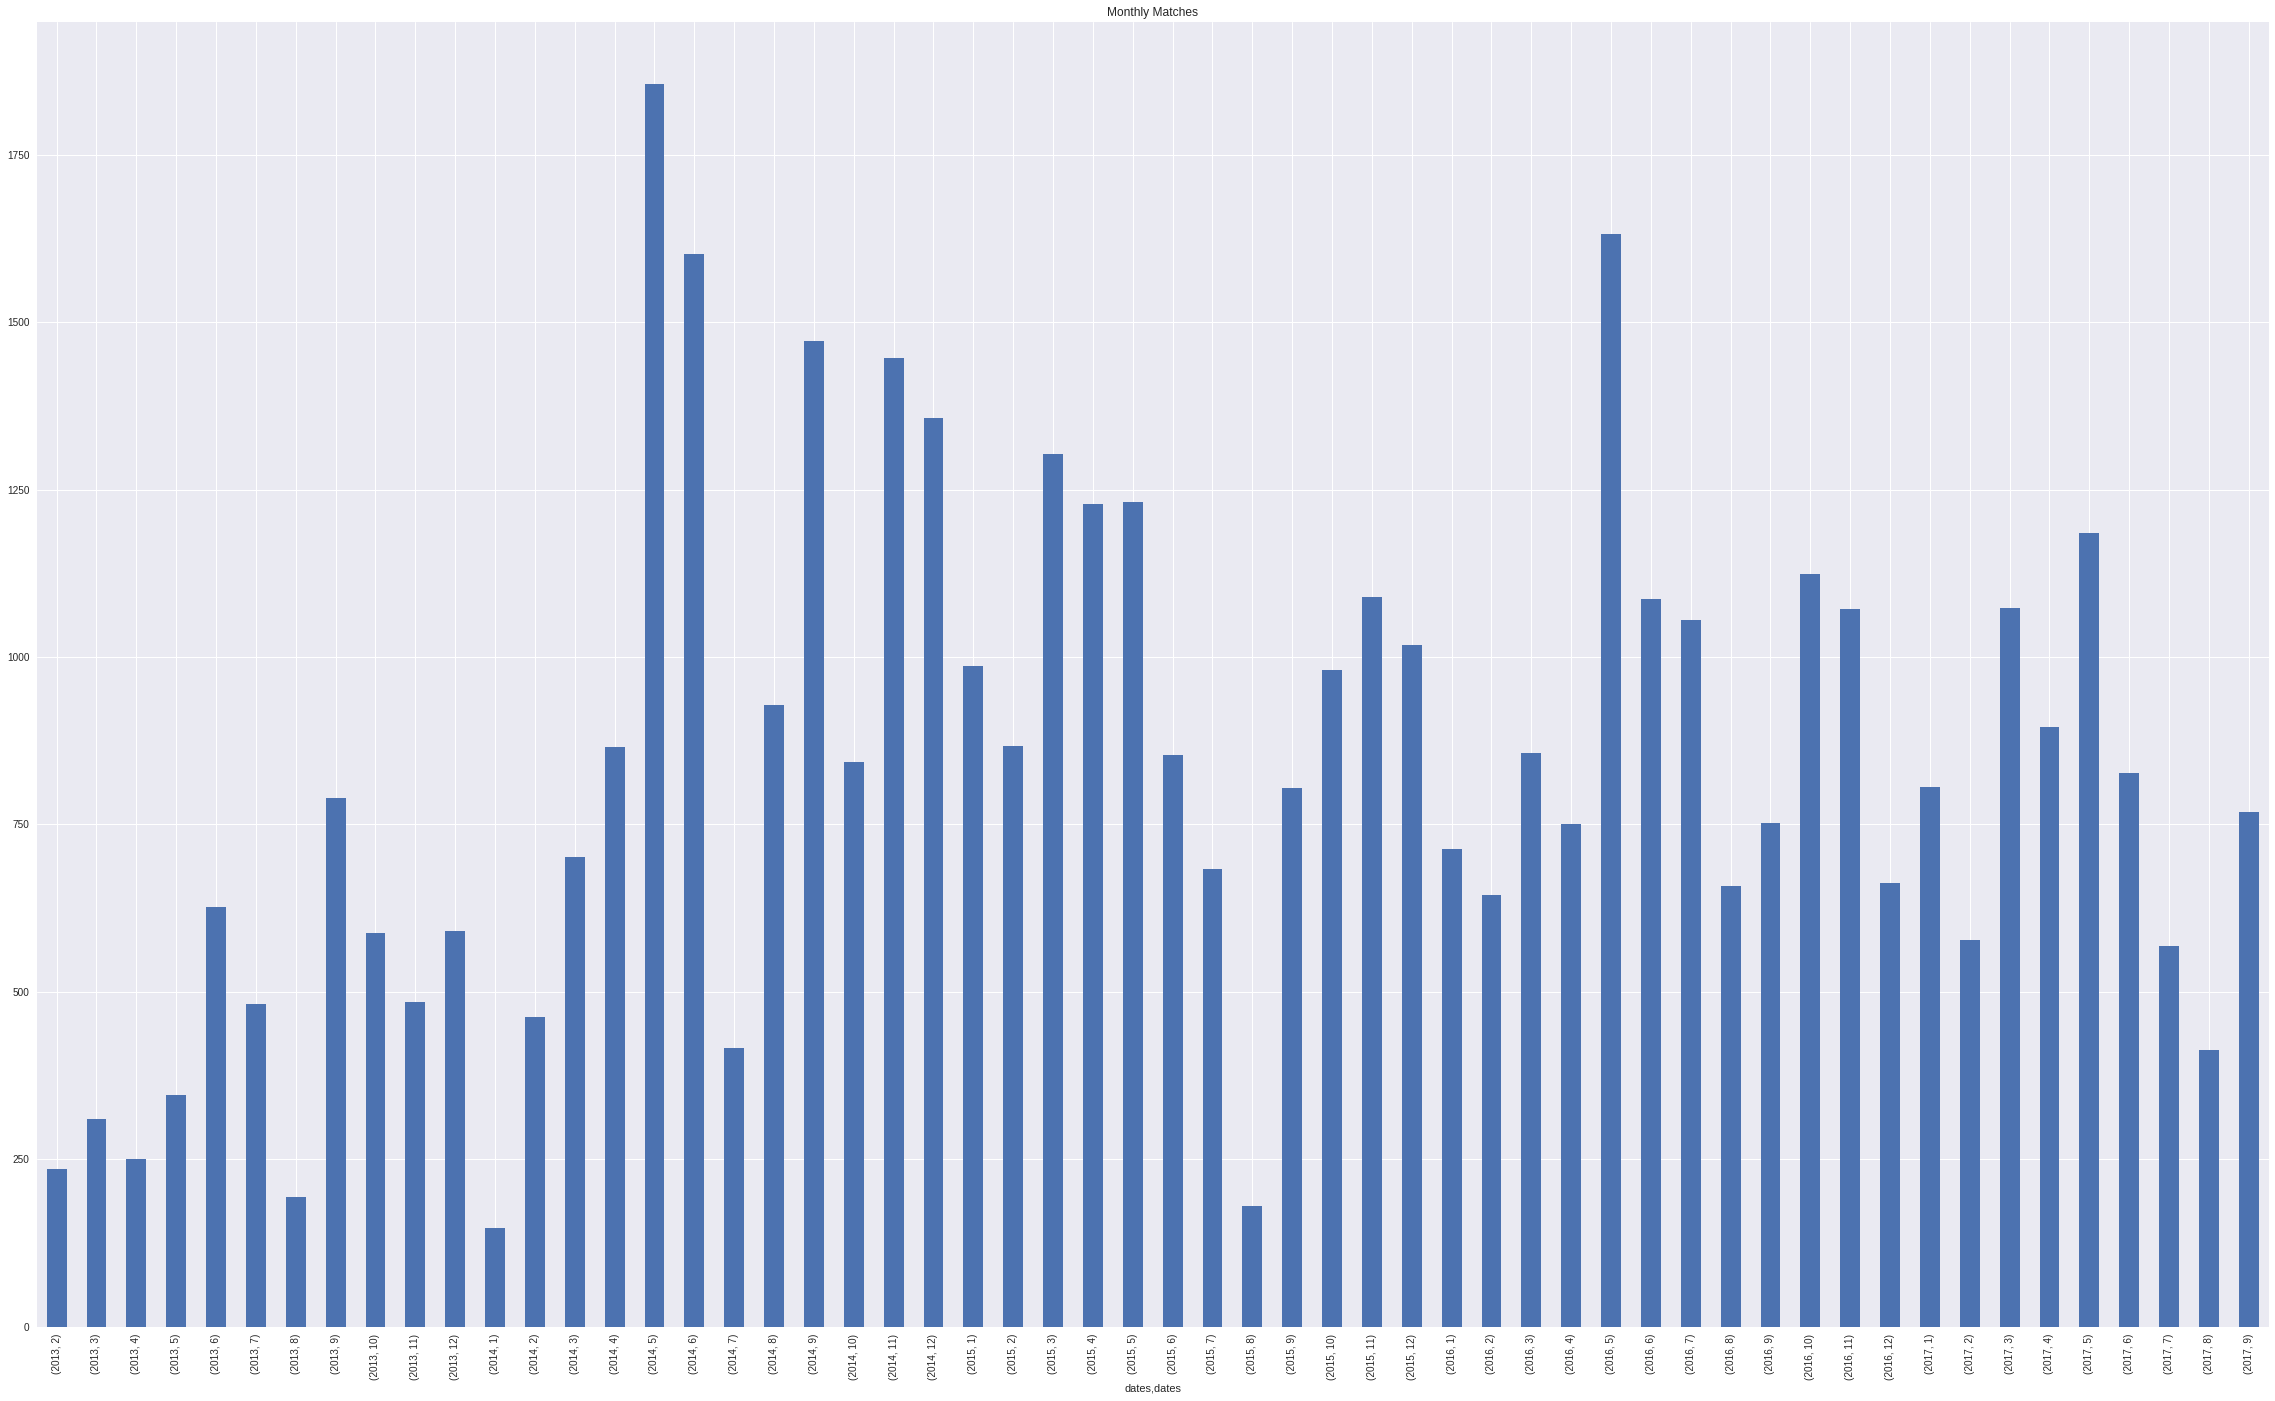

In [177]:
start_dates = pd.to_datetime(start_times_df['start_time'], unit='s')
start_times_df['dates'] = start_dates
plt.figure(figsize=(40, 24))
start_times_df.groupby([start_times_df["dates"].dt.year, start_times_df["dates"].dt.month]).count()['start_time'].plot(kind="bar")
plt.title('Monthly Matches')
plt.show()

Winrate by heroes

In [79]:
radiant_winrates = dict()
dire_winrates = dict()
hero_winrates = dict()
for hero_id in xrange(1, 115):
    radiant_matches = dummies_df[(dummies_df['radiant_' + str(hero_id)] == 1)]
    dire_matches = dummies_df[(dummies_df['dire_' + str(hero_id)] == 1)]
    radiant_wins = radiant_matches['radiant_win'].sum()
    dire_wins = ( dire_matches.shape[0] - dire_matches['radiant_win'].sum())
    radiant_winrate = radiant_wins / radiant_matches.shape[0] if radiant_matches.shape[0] > 0 else 0
    dire_winrate = dire_wins / dire_matches.shape[0] if dire_matches.shape[0] > 0 else 0
    radiant_winrates[hero_id] = radiant_winrate
    dire_winrates[hero_id] = dire_winrate
    hero_winrates[hero_id] = (radiant_wins + dire_wins) / (radiant_matches.shape[0] + dire_matches.shape[0])\
        if radiant_matches.shape[0] + dire_matches.shape[0] > 0 else 0

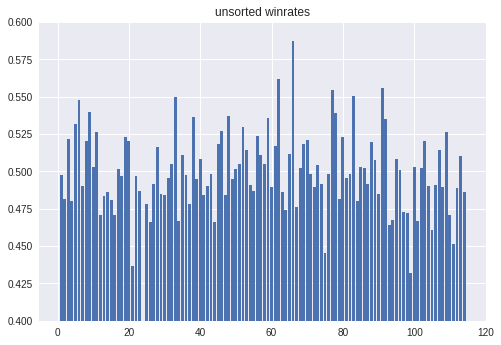

In [176]:
plt.bar(left=hero_winrates.keys(), height=hero_winrates.values())
plt.ylim(ymin=.4, ymax=.6)
plt.title('unsorted winrates')
plt.show()

In [85]:
# wtf?
heroes_df[heroes_df['id'] == 24]

,id,attack_type,legs,localized_name,name,primary_attr,roles


Heroes with highest winrates

In [95]:
heroes_by_winrate = sorted( hero_winrates.keys(), key=lambda k: hero_winrates[k], reverse=True)

In [147]:
top20 = np.array(heroes_by_winrate[:20])

Clearly we are looking at data for an older patch.

In [148]:
heroes_df[heroes_df['id'].isin(top20)]['name']

9                npc_dota_hero_huskar
10        npc_dota_hero_bounty_hunter
16           npc_dota_hero_lone_druid
24           npc_dota_hero_brewmaster
38     npc_dota_hero_templar_assassin
40               npc_dota_hero_clinkz
50              npc_dota_hero_leshrac
53                npc_dota_hero_lycan
55               npc_dota_hero_visage
58          npc_dota_hero_terrorblade
59               npc_dota_hero_enigma
60          npc_dota_hero_beastmaster
62                 npc_dota_hero_luna
65               npc_dota_hero_treant
70            npc_dota_hero_nevermore
97                 npc_dota_hero_chen
99                 npc_dota_hero_wisp
106      npc_dota_hero_crystal_maiden
107         npc_dota_hero_drow_ranger
112              npc_dota_hero_mirana
Name: name, dtype: object

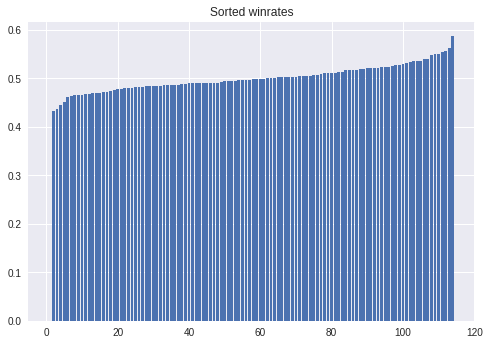

In [175]:
plt.bar(left=range(1, 115), height=sorted(hero_winrates.values()))
plt.title('Sorted winrates')
plt.show()

Hero pick-rates

In [155]:
pickrates = dict()
picks = dummies_df.iloc[:, 4:].sum(axis=0)
for i in xrange(1, 115):
    dire_picks = picks['dire_' + str(i)]
    radiant_picks = picks['radiant_' + str(i)]
    pickrates[i] = (dire_picks + radiant_picks) / dummies_df.shape[0]


In [156]:
pickrates

{1: 0.066422097539922315,
 2: 0.095770392749244718,
 3: 0.094561933534743209,
 4: 0.025766076823478635,
 5: 0.097583081570996974,
 6: 0.063854121709106607,
 7: 0.18554164868364265,
 8: 0.16810530858869227,
 9: 0.15962451445835132,
 10: 0.069939577039274919,
 11: 0.13584376348726801,
 12: 0.047885196374622359,
 13: 0.15116529995684075,
 14: 0.026240828657747087,
 15: 0.098036253776435045,
 16: 0.1397928355632283,
 17: 0.11432887354337505,
 18: 0.068709538195943026,
 19: 0.049719464825205006,
 20: 0.21717738454898575,
 21: 0.081614156236512733,
 22: 0.060056107034958998,
 23: 0.059149762624082863,
 24: 0.0,
 25: 0.10623651273198101,
 26: 0.15699179974104446,
 27: 0.089900733707380234,
 28: 0.1350453172205438,
 29: 0.1253992231333621,
 30: 0.15891238670694863,
 31: 0.073262839879154079,
 32: 0.029607250755287008,
 33: 0.061545101424255504,
 34: 0.066076823478636165,
 35: 0.044454035390591284,
 36: 0.031398359948208894,
 37: 0.050647388864911526,
 38: 0.088088044885627964,
 39: 0.155675442

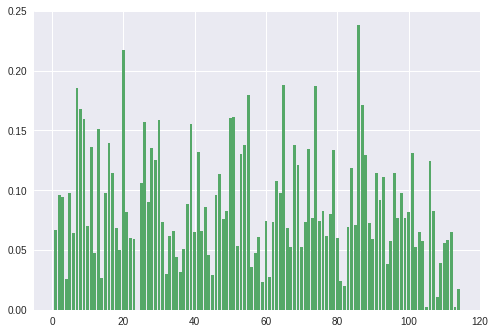

In [158]:
plt.bar(left=pickrates.keys(), height=pickrates.values())
plt.show()

In [161]:
heroes_by_pickrate = sorted(pickrates.keys(), key=lambda k: pickrates[k], reverse=True)
top15 = heroes_by_pickrate[:15]

In [163]:
heroes_df[heroes_df['id'].isin(top15)]['name']

3           npc_dota_hero_dark_seer
11           npc_dota_hero_batrider
13            npc_dota_hero_invoker
33             npc_dota_hero_dazzle
35       npc_dota_hero_witch_doctor
39         npc_dota_hero_rattletrap
54          npc_dota_hero_disruptor
71               npc_dota_hero_puck
73        npc_dota_hero_queenofpain
90     npc_dota_hero_vengefulspirit
93               npc_dota_hero_lion
98             npc_dota_hero_rubick
110       npc_dota_hero_earthshaker
111        npc_dota_hero_juggernaut
112            npc_dota_hero_mirana
Name: name, dtype: object

In [169]:
min(pickrates.values()[:23] + pickrates.values()[24:]) # besides hero_id = 4, what is the lowest pick_rate?

0.0020716443677168753

In [166]:
max(pickrates.values())

0.23819594302977989

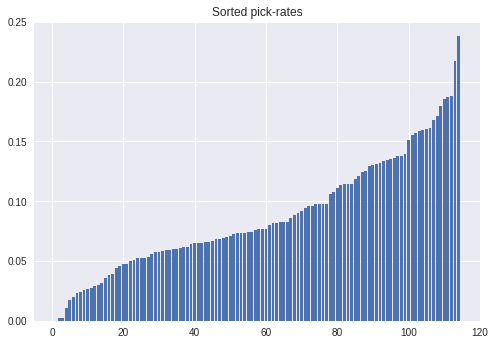

In [172]:
plt.bar(range(1, 115), sorted(pickrates.values()))
plt.title('Sorted pick-rates')
plt.show()

# Modeling
1. Logistic Regression
2. kNN
3. Decision Trees
4. Random Forests
5. Boosting